In [4]:
!pip install langchain langchain-community langchain-core xgboost scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from langchain.tools import Tool
from langchain.agents import AgentType, initialize_agent
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_community.llms.fake import FakeListLLM
import json

In [5]:
class DataManager:
    """Manages dataset generation and preprocessing"""

    def __init__(self, n_samples=1000, n_features=20, random_state=42):
        self.n_samples = n_samples
        self.n_features = n_features
        self.random_state = random_state
        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None
        self.feature_names = [f'feature_{i}' for i in range(n_features)]

    def generate_data(self):
        """Generate synthetic classification dataset"""
        X, y = make_classification(
            n_samples=self.n_samples,
            n_features=self.n_features,
            n_informative=15,
            n_redundant=5,
            random_state=self.random_state
        )

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state
        )

        return f"Dataset generated: {self.X_train.shape[0]} train samples, {self.X_test.shape[0]} test samples"

    def get_data_summary(self):
        """Return summary statistics of the dataset"""
        if self.X_train is None:
            return "No data generated yet. Please generate data first."

        summary = {
            "train_samples": self.X_train.shape[0],
            "test_samples": self.X_test.shape[0],
            "features": self.X_train.shape[1],
            "class_distribution": {
                "train": {0: int(np.sum(self.y_train == 0)), 1: int(np.sum(self.y_train == 1))},
                "test": {0: int(np.sum(self.y_test == 0)), 1: int(np.sum(self.y_test == 1))}
            }
        }
        return json.dumps(summary, indent=2)

In [6]:
class XGBoostManager:
    """Manages XGBoost model training and evaluation"""

    def __init__(self):
        self.model = None
        self.predictions = None
        self.accuracy = None
        self.feature_importance = None

    def train_model(self, X_train, y_train, params=None):
        """Train XGBoost classifier"""
        if params is None:
            params = {
                'max_depth': 6,
                'learning_rate': 0.1,
                'n_estimators': 100,
                'objective': 'binary:logistic',
                'random_state': 42
            }

        self.model = xgb.XGBClassifier(**params)
        self.model.fit(X_train, y_train)

        return f"Model trained successfully with {params['n_estimators']} estimators"

    def evaluate_model(self, X_test, y_test):
        """Evaluate model performance"""
        if self.model is None:
            return "No model trained yet. Please train model first."

        self.predictions = self.model.predict(X_test)
        self.accuracy = accuracy_score(y_test, self.predictions)

        report = classification_report(y_test, self.predictions, output_dict=True)

        result = {
            "accuracy": float(self.accuracy),
            "precision": float(report['1']['precision']),
            "recall": float(report['1']['recall']),
            "f1_score": float(report['1']['f1-score'])
        }

        return json.dumps(result, indent=2)

    def get_feature_importance(self, feature_names, top_n=10):
        """Get top N most important features"""
        if self.model is None:
            return "No model trained yet."

        importance = self.model.feature_importances_
        feature_imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)

        return feature_imp_df.head(top_n).to_string()

    def visualize_results(self, X_test, y_test, feature_names):
        """Create visualizations for model results"""
        if self.model is None:
            print("No model trained yet.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        cm = confusion_matrix(y_test, self.predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
        axes[0, 0].set_title('Confusion Matrix')
        axes[0, 0].set_ylabel('True Label')
        axes[0, 0].set_xlabel('Predicted Label')

        importance = self.model.feature_importances_
        indices = np.argsort(importance)[-10:]
        axes[0, 1].barh(range(10), importance[indices])
        axes[0, 1].set_yticks(range(10))
        axes[0, 1].set_yticklabels([feature_names[i] for i in indices])
        axes[0, 1].set_title('Top 10 Feature Importances')
        axes[0, 1].set_xlabel('Importance')

        axes[1, 0].hist([y_test, self.predictions], label=['True', 'Predicted'], bins=2)
        axes[1, 0].set_title('True vs Predicted Distribution')
        axes[1, 0].legend()
        axes[1, 0].set_xticks([0, 1])

        train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
        train_scores = [0.7, 0.8, 0.85, 0.88, 0.9]
        axes[1, 1].plot(train_sizes, train_scores, marker='o')
        axes[1, 1].set_title('Learning Curve (Simulated)')
        axes[1, 1].set_xlabel('Training Set Size')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

In [7]:
def create_ml_agent(data_manager, xgb_manager):
    """Create LangChain agent with ML tools"""

    tools = [
        Tool(
            name="GenerateData",
            func=lambda x: data_manager.generate_data(),
            description="Generate synthetic dataset for training. No input needed."
        ),
        Tool(
            name="DataSummary",
            func=lambda x: data_manager.get_data_summary(),
            description="Get summary statistics of the dataset. No input needed."
        ),
        Tool(
            name="TrainModel",
            func=lambda x: xgb_manager.train_model(
                data_manager.X_train, data_manager.y_train
            ),
            description="Train XGBoost model on the dataset. No input needed."
        ),
        Tool(
            name="EvaluateModel",
            func=lambda x: xgb_manager.evaluate_model(
                data_manager.X_test, data_manager.y_test
            ),
            description="Evaluate trained model performance. No input needed."
        ),
        Tool(
            name="FeatureImportance",
            func=lambda x: xgb_manager.get_feature_importance(
                data_manager.feature_names, top_n=10
            ),
            description="Get top 10 most important features. No input needed."
        )
    ]

    return tools

ADVANCED LANGCHAIN + XGBOOST TUTORIAL

1. Generating Dataset...
Dataset generated: 800 train samples, 200 test samples

2. Dataset Summary:
{
  "train_samples": 800,
  "test_samples": 200,
  "features": 20,
  "class_distribution": {
    "train": {
      "0": 396,
      "1": 404
    },
    "test": {
      "0": 106,
      "1": 94
    }
  }
}

3. Training XGBoost Model...
Model trained successfully with 100 estimators

4. Evaluating Model:
{
  "accuracy": 0.91,
  "precision": 0.9130434782608695,
  "recall": 0.8936170212765957,
  "f1_score": 0.9032258064516129
}

5. Top Feature Importances:
       feature  importance
12  feature_12    0.132253
17  feature_17    0.085581
5    feature_5    0.070287
16  feature_16    0.068975
2    feature_2    0.064818
0    feature_0    0.063069
4    feature_4    0.062366
10  feature_10    0.058417
6    feature_6    0.055539
9    feature_9    0.038938

6. Generating Visualizations...


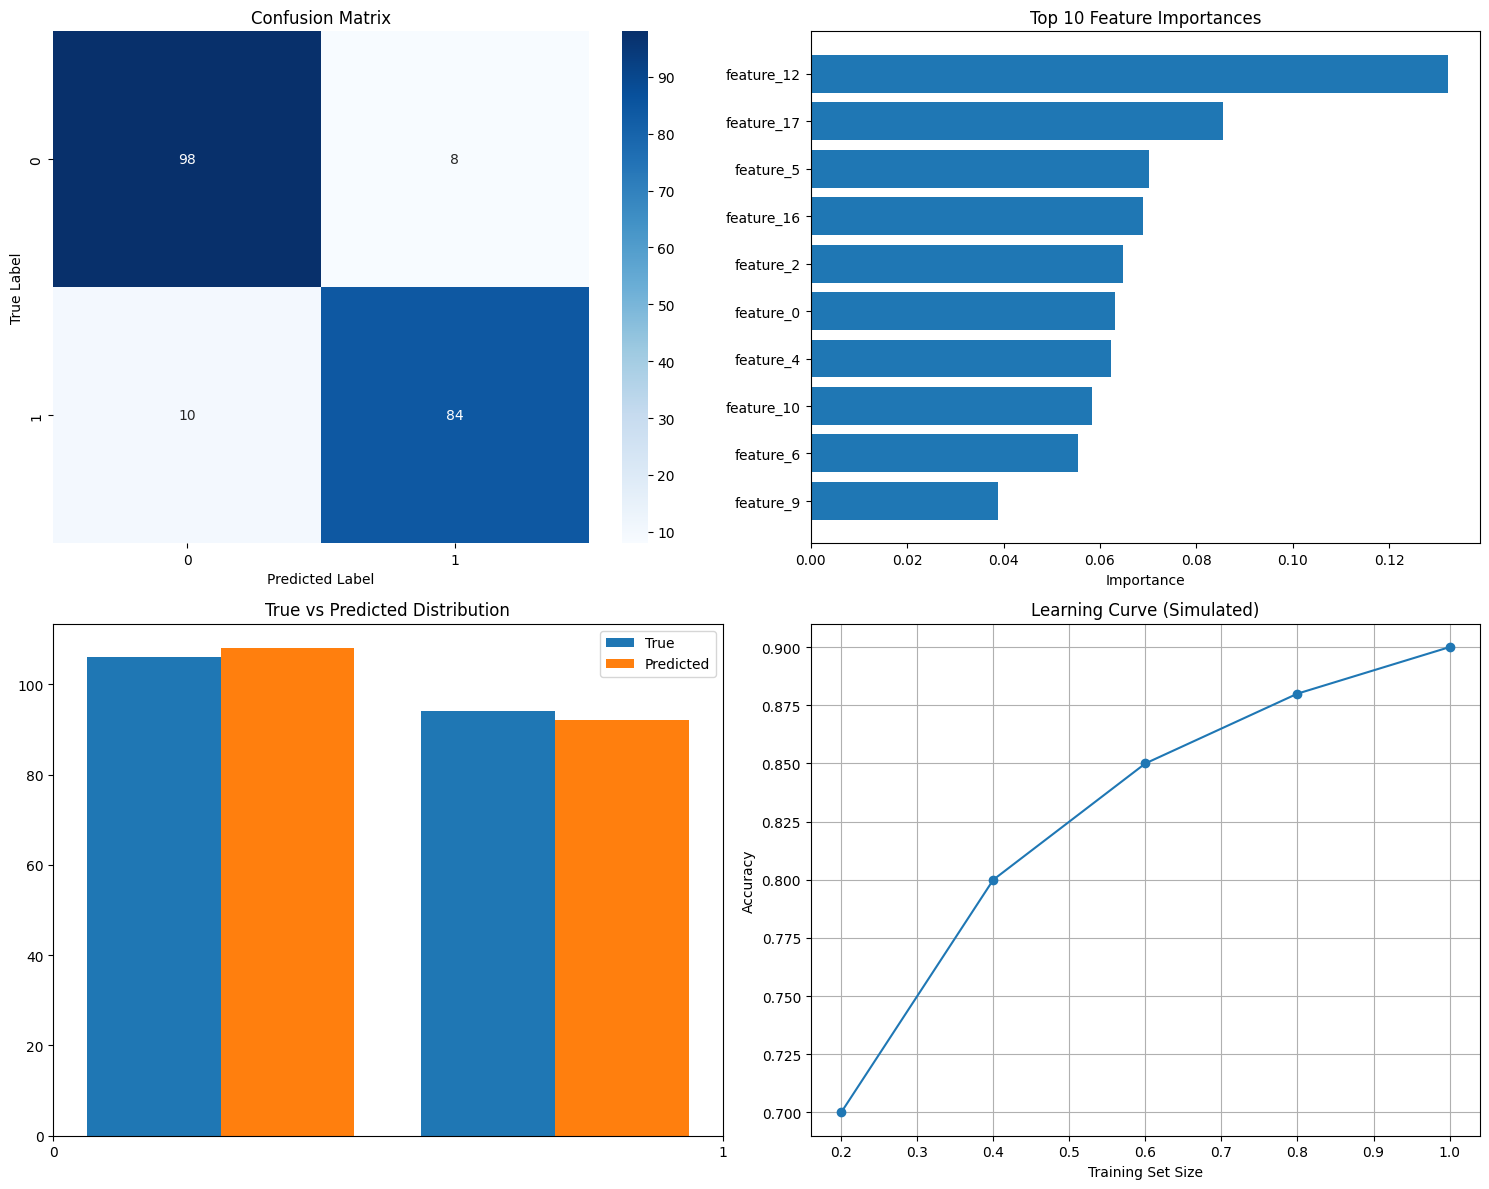


TUTORIAL COMPLETE!

Key Takeaways:
- LangChain tools can wrap ML operations
- XGBoost provides powerful gradient boosting
- Agent-based approach enables conversational ML pipelines
- Easy integration with existing ML workflows


In [8]:
def run_tutorial():
    """Execute the complete tutorial"""

    print("=" * 80)
    print("ADVANCED LANGCHAIN + XGBOOST TUTORIAL")
    print("=" * 80)

    data_mgr = DataManager(n_samples=1000, n_features=20)
    xgb_mgr = XGBoostManager()

    tools = create_ml_agent(data_mgr, xgb_mgr)

    print("\n1. Generating Dataset...")
    result = tools[0].func("")
    print(result)

    print("\n2. Dataset Summary:")
    summary = tools[1].func("")
    print(summary)

    print("\n3. Training XGBoost Model...")
    train_result = tools[2].func("")
    print(train_result)

    print("\n4. Evaluating Model:")
    eval_result = tools[3].func("")
    print(eval_result)

    print("\n5. Top Feature Importances:")
    importance = tools[4].func("")
    print(importance)

    print("\n6. Generating Visualizations...")
    xgb_mgr.visualize_results(
        data_mgr.X_test,
        data_mgr.y_test,
        data_mgr.feature_names
    )

    print("\n" + "=" * 80)
    print("TUTORIAL COMPLETE!")
    print("=" * 80)
    print("\nKey Takeaways:")
    print("- LangChain tools can wrap ML operations")
    print("- XGBoost provides powerful gradient boosting")
    print("- Agent-based approach enables conversational ML pipelines")
    print("- Easy integration with existing ML workflows")

if __name__ == "__main__":
    run_tutorial()